## 0.0. Init settings and libraries

In [763]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

%matplotlib inline
import matplotlib.pyplot as plt # библиотека визуализации
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10, 8)})

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [764]:
# Standard python libraries
import os
import time


# Essential DS libraries
import category_encoders as ce
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

from comet_ml import Experiment
import Handlers as hd
import re

## 0.2. Fix package version

In [765]:
# !pip freeze > requirements.txt

## 0.3. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [766]:
# Base settings
RANDOM_STATE = 42
TEST_SIZE = 0.2
TARGET_FEATURE = 'reviewer_score'
SUBMISSION_FILE_NAME = 'just_filters.csv'

# LightAutoML settings
USE_LAML = False
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 30 * 60 # mins

# Comet_ML settings
USE_COMET_ML = False
COMET_PROJECT_NAME = 'Project3'

In [767]:
# Списки для добавления имен столбцов по ходу анализа
category_nominal_columns = set()
category_ordinal_columns = set()

## 0.4. Init Comet_ML

In [768]:
if USE_COMET_ML:
    experiment = Experiment(
        api_key="I1vM5jywyHjyrHOHaffYqCv6z",
        project_name=COMET_PROJECT_NAME,
        workspace="chepell",
    )

In [769]:
# Save text info about experiment on Comet_ML
if USE_COMET_ML:
    text = SUBMISSION_FILE_NAME + '\nГод в возраст и фильтрация по тьюки\n'
    text = text + 'Фильтрация милей по тьюки\n'
    text = text + 'Фильтрация целевого признака по логике и тьюки\n'

    experiment.log_text(text, step=None, metadata=None)

## 0.5. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [770]:
if USE_LAML:
    np.random.seed(RANDOM_STATE)
    torch.set_num_threads(N_THREADS)

## 0.6. Data loading
Let's check the data we have:

In [771]:
INPUT_DIR = 'data/'

In [772]:
train_data = pd.read_csv(INPUT_DIR + 'hotels_train.csv.zip')
print(train_data.shape)
train_data.head()

(386803, 17)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.00,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.51,-0.14
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.30,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.52,-0.12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.90,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.50,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.85,2.33
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.00,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.89,2.39
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.50,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.60,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.39,4.85


In [773]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [774]:
test_data = pd.read_csv(INPUT_DIR + 'hotels_test.csv.zip')
print(test_data.shape)
test_data.head()

(128935, 16)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.10,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.53,9.17
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.60,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.39,4.83
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.30,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.39,2.16
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.10,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.48,9.20
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.10,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.37,4.89


In [775]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [776]:
submission = pd.read_csv(INPUT_DIR + 'submission.csv.zip')
print(submission.shape)
submission.head()

(128935, 2)


,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [777]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


## 0.7. Merge datasets

In [778]:
full_data = hd.merge_train_and_test_to_full(train_data, test_data, TARGET_FEATURE)
full_data.shape

(515738, 18)

## 0.8. Cleaning Data

### Duplicates

In [779]:
duplicate_mask = full_data.duplicated()

In [780]:
# Всего дубликатов
duplicate_mask.sum()

336

In [781]:
# % дубликатов от всего датасета
duplicate_mask.mean() * 100

0.06514935878294793

In [782]:
# Можно добавить отдельный признак, что запись дубликат
# Но данный признак будет малоинформативным т.к. будет составлять 0.065% от всей выборки
# full_data['duplicate'] = duplicate_mask

In [783]:
# Сами дубликаты
duplicate_data = full_data[duplicate_mask]
duplicate_data


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,reviewer_score,dataset
21413,9 Rue Sainte Beuve 6th arr 75006 Paris France,22,9/27/2015,8.90,Hotel Le Sainte Beuve,Costa Rica,No Negative,0,143,Ir s a lovely boutique hotel full of Parisian...,53,4,"[' Leisure trip ', ' Family with older childre...",676 day,48.84,2.33,10.00,train
53110,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,9/25/2016,9.00,H tel Baume,Lebanon,nothing at all,4,253,bed was great staff are wonderful location ve...,10,1,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",312 day,48.85,2.34,10.00,train
54461,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/2/2016,7.90,H tel Concorde Montparnasse,Israel,The room to far from elevator,7,2515,Staff very nice and helpful Breakfast was per...,17,2,"[' Couple ', ' Classic Twin Room ', ' Stayed 3...",366 day,48.84,2.32,8.30,train
56542,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,7/2/2017,9.00,H tel Baume,Romania,Breakfast was a huge joke It was the worst po...,19,253,Room was great nice and spacious appartment f...,14,7,"[' Leisure trip ', ' Family with young childre...",32 days,48.85,2.34,7.90,train
65789,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,8/11/2015,9.00,H tel Baume,United Kingdom,No Negative,0,253,Friendly reception staff clean bathroom and l...,11,1,"[' Leisure trip ', ' Couple ', ' Superior Doub...",723 day,48.85,2.34,10.00,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499212,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/23/2016,7.90,H tel Concorde Montparnasse,United States of America,Nothing I will stay at this hotel again on my...,24,2515,The staff was very helpful and the property w...,21,8,"[' Leisure trip ', ' Family with older childre...",437 day,48.84,2.32,0.00,test
506924,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,2/1/2016,7.90,H tel Concorde Montparnasse,Malta,beautiful wiew,3,2515,cleanness staff very friendly very helpful,7,2,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",549 day,48.84,2.32,0.00,test
509781,167 rue de Rome 17th arr 75017 Paris France,11,12/12/2016,6.80,Villa Eugenie,Canada,Listed above,3,165,It was a terrible stat unfriendly staff very ...,13,1,"[' Business trip ', ' Solo traveler ', ' Stand...",234 day,48.89,2.31,0.00,test
512237,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,9/22/2015,7.90,H tel Concorde Montparnasse,Germany,Breakfast is pretty expensive however good,8,2515,Very good location good connections with Metr...,24,5,"[' Leisure trip ', ' Group ', ' Classic Twin R...",681 day,48.84,2.32,0.00,test


In [784]:
# Распределение дубликатов по выборкам
duplicate_data.groupby('dataset').agg({'hotel_name': 'count'})


,hotel_name
dataset,
test,29
train,307


In [785]:
# Удаляю дубликаты
full_data.drop_duplicates(inplace=True)

### Null and Empty features

In [786]:
hd.get_columns_isnull_info_df(full_data)

lng   0.63
lat   0.63
dtype: float64

### Изучаю lat and lng

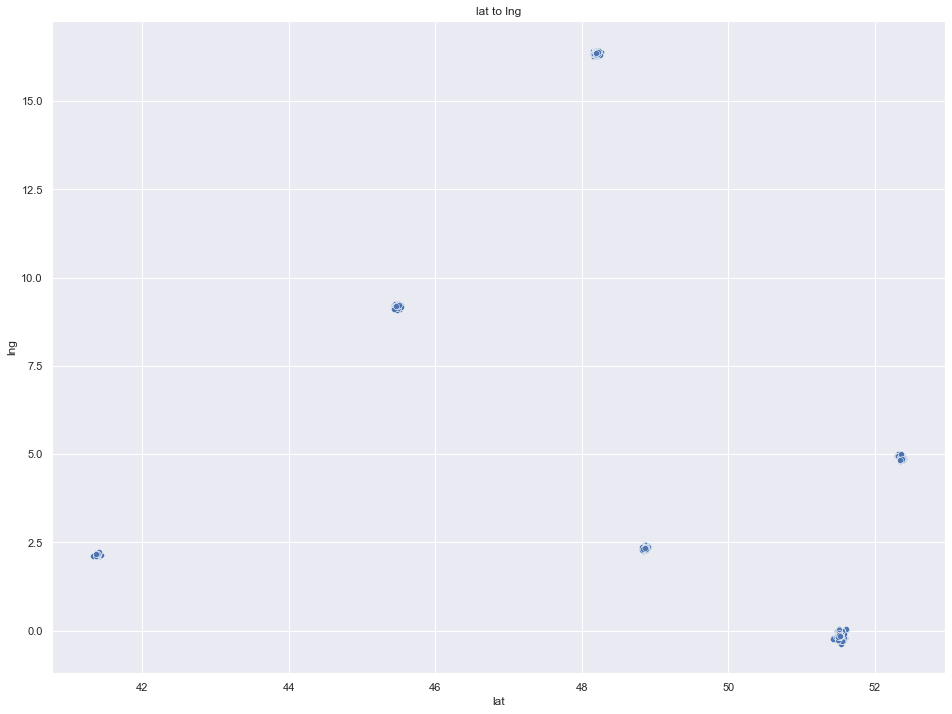

In [787]:
# Диаграмма рассеяния отлично показывает скопления координат. Фактически имеем 6 локаций где находятся отели
fig = plt.figure(figsize=(16, 12))
plot = sns.scatterplot(x=full_data['lat'], y=full_data['lng'])
plot.set_title('lat to lng')
fig.show()

In [788]:
# Заполняю пропуски по простому, медианой, это будет правое нижнее скопление
vals = {'lat': full_data['lat'].median(),
        'lng': full_data['lng'].median()}
full_data.fillna(value=vals, inplace=True)

## 1.0. EDA

### Анализ признаков
#### Если количество уникальных признаков (Count Unique < 150), то можно думать о переводе признака в категориальный

In [789]:
hd.get_top_unique_values(full_data)

,Column Name,Count Unique,% Unique,Top Value,Top Value Count,Top Value %
0,hotel_address,1493,0.29,163 Marsh Wall Docklands Tower Hamlets London ...,4789,0.93
1,additional_number_of_scoring,480,0.09,2682,4789,0.93
2,review_date,731,0.14,8/2/2017,2584,0.50
3,average_score,34,0.01,8.40,41222,8.00
4,hotel_name,1492,0.29,Britannia International Hotel Canary Wharf,4789,0.93
5,reviewer_nationality,227,0.04,United Kingdom,245158,47.57
6,negative_review,330011,64.03,No Negative,127807,24.80
7,review_total_negative_word_counts,402,0.08,0,127807,24.80
8,total_number_of_reviews,1142,0.22,9086,4789,0.93
9,positive_review,412601,80.05,No Positive,35923,6.97


average_score можно перевести в категориальный признак т.к. всего 34 уникальных значения

In [790]:
# Ишу малоинформативные признаки
hd.get_low_inform_features_list(full_data)

'Нет малоинформативных признаков!'

### EXPLORE: review_date

In [791]:
# Преобразую дату
full_data['review_date'] = pd.to_datetime(full_data['review_date'])

In [792]:
full_data['review_date'].value_counts(True) * 100

2017-08-02   0.50
2016-09-15   0.45
2017-04-05   0.44
2016-08-30   0.38
2016-02-16   0.38
             ... 
2016-09-10   0.04
2015-11-27   0.04
2017-04-03   0.04
2017-04-01   0.03
2017-04-02   0.03
Name: review_date, Length: 731, dtype: float64

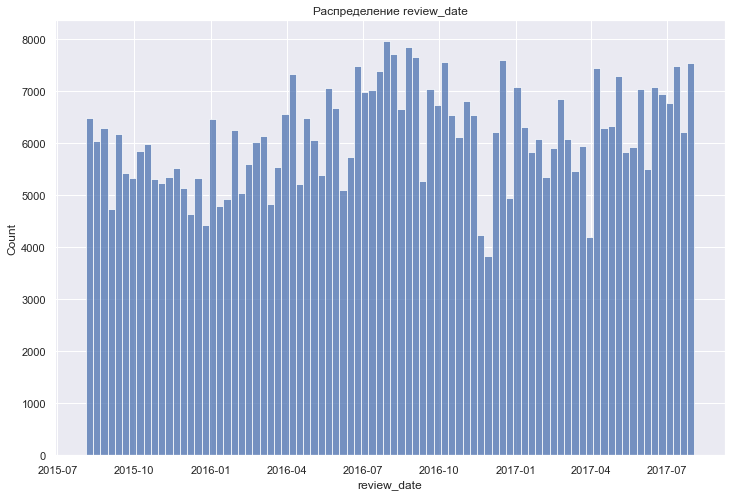

In [793]:
# Распределение похоже на забор, 
# т.е. более-менее равномерно каждый день выставлялись оценки отелям
fig = plt.figure(figsize=(12, 8))
hist = sns.histplot(data=full_data, x='review_date')
hist.set_title('Распределение review_date');

### Дни недели

In [794]:
full_data['day_of_week'] = full_data['review_date'].dt.day_name()

In [795]:
# Меньше всего обзоров пишется в пт и сб, все хотят отдыхать 
# или как раз бронирут отели и едут на коротких отдых в пт веречером
full_data['day_of_week'].value_counts(True) * 100

Tuesday     23.45
Sunday      16.28
Monday      15.73
Thursday    14.44
Wednesday   11.36
Saturday    10.05
Friday       8.67
Name: day_of_week, dtype: float64

In [796]:
# День недели - категориальный номинальный признак. преобразую
full_data['day_of_week'] = full_data['day_of_week'].astype('category')
# Добавляю имя в список
category_nominal_columns.add('day_of_week')

### Месяцы

In [797]:
full_data['month'] = full_data['review_date'].dt.month

In [798]:
full_data['month'].value_counts(True) * 100

8    9.82
7    9.56
5    9.02
10   8.50
6    8.32
4    8.32
9    8.22
1    8.17
3    7.97
12   7.68
2    7.44
11   6.97
Name: month, dtype: float64

In [799]:
# Добавляю имя
category_nominal_columns.add('month')

### Кварталы

In [800]:
full_data['quarter'] = full_data['review_date'].dt.quarter

In [801]:
# Чуть больше отчетов пишется в 3ем квартале, во второй половине лета и начале осени, после летних отпусков
full_data['quarter'].value_counts(True) * 100

3   27.61
2   25.65
1   23.59
4   23.15
Name: quarter, dtype: float64

Удаляю исходный признак review_date

In [802]:
# full_data.drop('review_date', axis=1, inplace=True)

### EXPLORE: average_score
Похоже на порядковый категориальный признак

In [803]:
# Значения лежат в промежутке 5-10
full_data['average_score'].describe()

count   515402.00
mean         8.40
std          0.55
min          5.20
25%          8.10
50%          8.40
75%          8.80
max          9.80
Name: average_score, dtype: float64

In [804]:
# 34 уникальных значения
full_data['average_score'].nunique()

34

In [805]:
full_data['average_score'].value_counts(True) * 100

8.40   8.00
8.10   7.40
8.50   7.39
8.70   7.33
8.60   7.17
8.20   6.76
8.30   6.38
8.80   5.98
8.90   5.53
8.00   4.33
9.10   4.15
9.00   4.07
7.80   3.86
7.90   2.90
7.50   2.66
9.20   2.51
9.30   2.46
7.70   2.30
9.40   1.81
7.10   1.32
7.60   1.30
7.40   1.22
7.30   0.78
7.00   0.76
6.90   0.34
6.80   0.26
9.50   0.23
6.40   0.23
6.70   0.19
9.60   0.18
7.20   0.13
6.60   0.08
5.20   0.01
9.80   0.01
Name: average_score, dtype: float64

Распределение признака похоже на нормальное

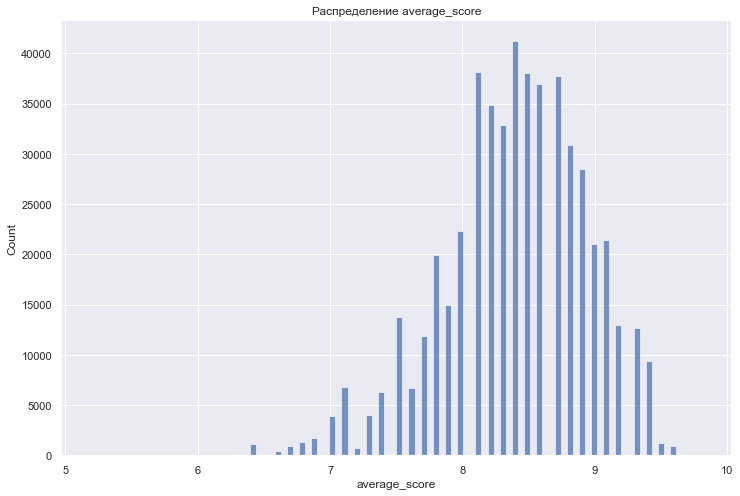

In [806]:
fig = plt.figure(figsize=(12, 8))
hist = sns.histplot(data=full_data, x='average_score', bins=100)
hist.set_title('Распределение average_score');

In [807]:
# hd.QQ_Plots(full_data, 'average_score')

### average_score, варианты разбиения на категории

In [808]:
# full_data['average_score_cat'] = pd.cut(full_data['average_score'], bins=[5, 6, 7, 8, 9, 10], include_lowest=True)
# full_data['average_score_cat'] = pd.cut(full_data['average_score'], bins=list(np.arange(5, 10.5, 0.5)), include_lowest=True) # C шагом 0.5
# full_data['average_score_cat'] = pd.qcut(full_data['average_score'], q=5) # 5 бинов с примерно одинаковым распределением внутри

# Добавляю новый признак
# lab_list = ['5-6', '7', '7+', '8', '8+', '9', '9+']
# order_list = list(range(7))

# full_data['average_score_cat'] = pd.cut(full_data['average_score'], bins=[5, 7, 7.5, 8, 8.5, 9, 9.5, 10], labels=lab_list, include_lowest=True)

# Словарь для дальнейшей кодировки признака
# dict_for_ordinal = dict(zip(lab_list, order_list))

In [809]:
# Округляю, конвертирую в целое
full_data['average_score_int'] = full_data['average_score'].round().astype('int')

In [810]:
# Размерность снижается до 6 уникальных значений
# Категориальный порядковый признак
full_data['average_score_int'].value_counts(True) * 100

8    53.27
9    41.01
7     5.06
10    0.42
6     0.23
5     0.01
Name: average_score_int, dtype: float64

In [811]:
category_ordinal_columns.add('average_score_int')

Исходный признак пока не удаляю

### EXPLORE: hotel_address

In [812]:
# Визуальный анализ адресов показывает, что в самом конце идет название страны, перед этим город.
# Название страны из одного слова, кроме случаев United Kingdom, тогда город на 5ом месте с конца.
# full_data['hotel_address'].to_list()

### Получения страны из адреса

In [813]:
def country_feature(hotel_address):
    hotel_address = str(hotel_address)
    
    address_lst = hotel_address.split()
    
    last_word = address_lst[-1]
    
    if last_word == 'Kingdom':
        return 'United Kingdom'
    
    return last_word

In [814]:
full_data['country'] = full_data['hotel_address'].apply(country_feature)

In [815]:
# Получается всего 6 стран, country
# 50% отелей приходится на Великобританию
full_data['country'].value_counts(True) * 100

United Kingdom   50.89
Spain            11.67
France           11.56
Netherlands      11.10
Austria           7.55
Italy             7.22
Name: country, dtype: float64

In [816]:
# Это категориальный номинальный признак. Преобразую
full_data['country'] = full_data['country'].astype('category')

In [817]:
category_nominal_columns.add('country')

### Получение города из адреса

In [818]:
def city_feature(hotel_address):
    hotel_address = str(hotel_address)
    
    address_lst = hotel_address.split()
    
    last_word = address_lst[-1]
    
    if last_word == 'Kingdom':
        return address_lst[-5]
    
    return address_lst[-2]

In [819]:
full_data['city'] = full_data['hotel_address'].apply(city_feature)

In [820]:
# Всего 6 городов, как и стран. Получается по городу в стране.
# Два эти признака полностью дублируют друг друга, но пока оставляю, ничего не удаляю.
# Сейчас идет генерация признаков, отбор и удаление будет позже.
full_data['city'].value_counts(True) * 100

London      50.89
Barcelona   11.67
Paris       11.56
Amsterdam   11.10
Vienna       7.55
Milan        7.22
Name: city, dtype: float64

In [821]:
# Город это тоже категориальный номинальный признак
full_data['city'] = full_data['city'].astype('category')

In [822]:
category_nominal_columns.add('city')

### Внешние данные

In [823]:
# Информация по странам
countries_data = pd.read_csv('data\population_by_country_2020.zip')

In [824]:
# Оставляю только два признака, название страны и население
countries_data = countries_data.iloc[:, 0:2]
countries_data.columns = ['country', 'country_population']
countries_data

,country,country_population
0,China,1440297825
1,India,1382345085
2,United States,331341050
3,Indonesia,274021604
4,Pakistan,221612785
...,...,...
230,Montserrat,4993
231,Falkland Islands,3497
232,Niue,1628
233,Tokelau,1360


In [825]:
# Добавляю признак популяции в стране
full_data = full_data.merge(countries_data, on='country', how='left')

In [826]:
# Информация по городам
cities_data = pd.read_csv('data\worldcitiespop.zip')

In [827]:
cities_data = cities_data.iloc[:, [0, 1, 4]] # оставляю три признака
cities_data.columns = ['country_code', 'city', 'city_population'] # Переименовываю столбцы
cities_data['city'] = cities_data['city'].str.capitalize() # Город с большой буквы
cities_data = cities_data[cities_data['city_population'].notnull()] # Оставляю города где есть значение популяции
cities_data['city_population'] = cities_data['city_population'].astype('int') # Преобразую популяцию к целому числу, непонятно вообще почему тут был float
cities_data


,country_code,city,city_population
6,ad,Andorra la vella,20430
20,ad,Canillo,3292
32,ad,Encamp,11224
49,ad,La massana,7211
53,ad,Les escaldes,15854
...,...,...,...
3173646,zw,Redcliffe,38231
3173676,zw,Rusape,23761
3173737,zw,Shurugwi,17107
3173892,zw,Victoria falls,36702


In [828]:
country_codes = ['gb', 'es', 'fr', 'nl', 'at', 'it'] # коды стран в которых у нас есть отели
our_country_mask = cities_data['country_code'].apply(lambda x: x in country_codes) # маска для отбора только стран из списка выше

cities_data = cities_data[our_country_mask]
cities_data.drop('country_code', axis=1, inplace=True) # признак country_code больше не нужен
cities_data

,city,city_population
136102,Absam,6594
136111,Abtenau,5829
136311,Altach,6040
136379,Althofen,4833
136395,Altmunster,9652
...,...,...
2034331,Zuidhorn,18338
2034361,Zundert,20656
2034367,Zutphen,38399
2034416,Zwijndrecht,41148


In [829]:
# Добавляю признак популяции в городе
full_data = full_data.merge(cities_data, on=['city'], how='left')

In [830]:
# Доля города в населении всей страны в %, точность тут вряд ли важна, поэтому округляю и привожу к целому типу
full_data['share_of_country'] = (full_data['city_population'] / full_data['country_population'] * 100).round().astype('int')

In [831]:
full_data['share_of_country'].value_counts(True) * 100

11   50.89
3    23.23
4    11.10
17    7.55
2     7.22
Name: share_of_country, dtype: float64

### Страна и город
Могу получить дополнительный признак является ли город столицей

In [832]:
def is_capital_feature(city):
    # Складываю в список только столицы
    # Столица Италии - Рим, а не Милан
    # Столица Испании - Мадрид, а не Барселона
    capitals = ['London', 'Paris', 'Amsterdam', 'Vienna']
    
    if city in capitals:
        return True
    
    return False

In [833]:
full_data['is_capital'] = full_data['city'].apply(is_capital_feature)

In [834]:
# Это категориальный номинальный признак
category_nominal_columns.add('is_capital')

Признак hotel_address можно удалить, оттуда уже ничего больше вытаскивать не буду

In [835]:
full_data.drop('hotel_address', axis=1, inplace=True)

### EXPLORE: days_since_review

In [836]:
full_data['days_since_review'].describe()

count     515402
unique       731
top       1 days
freq        2584
Name: days_since_review, dtype: object

In [837]:
full_data['days_since_review'].unique()

<StringArray>
['531 day', '203 day', '289 day', '681 day', '516 day', '582 day', '77 days',
 '192 day', '618 day', '548 day',
 ...
 '251 day', '511 day', '125 day', '122 day', '477 day', '126 day', '701 day',
 '552 day', '257 day', '96 days']
Length: 731, dtype: string

In [838]:
# Функция для выделения из признака количества дней
def reformat_days_since_review(days_since_review):
    days_str = str(days_since_review)
    
    days = days_str.split()[0]
    
    return int(days)

In [839]:
full_data['days_since_review'] = full_data['days_since_review'].apply(reformat_days_since_review)

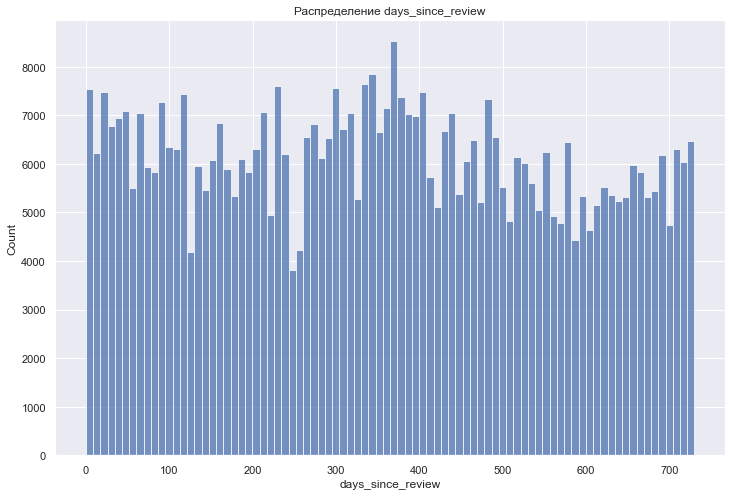

In [840]:
# Распределение похоже на забор, т.е. более-менее равномерно каждый день выставлялись оценки отелям
fig = plt.figure(figsize=(12, 8))
hist = sns.histplot(data=full_data, x='days_since_review')
hist.set_title('Распределение days_since_review');

### EXPLORE: reviewer_nationality

In [841]:
# Вижу лишние пробелы
full_data['reviewer_nationality'][0]

' United Kingdom '

In [842]:
# Удаляю лишние пробелы
full_data['reviewer_nationality'] = full_data['reviewer_nationality'].str.strip()

In [843]:
# Категориальный номинальный признак с огромным количеством уникальных категорий 227!
reviewer_nationality_counts = full_data['reviewer_nationality'].value_counts()
reviewer_nationality_counts

United Kingdom              245158
United States of America     35385
Australia                    21662
Ireland                      14819
United Arab Emirates         10230
                             ...  
Vatican City                     1
Cape Verde                       1
Palau                            1
Anguilla                         1
Tuvalu                           1
Name: reviewer_nationality, Length: 227, dtype: Int64

In [844]:
# Создаю бинарный признак, что ревьювер гражданин страны отелю которой он ставит оценку. ВОзможно к своим требования не такие как к чужим
full_data['is_reviewer_citizen'] = full_data['reviewer_nationality'] == full_data['country']

In [845]:
# 65% это иностранные туристы
full_data['is_reviewer_citizen'].value_counts(True) * 100

False   65.39
True    34.61
Name: is_reviewer_citizen, dtype: float64

In [846]:
# Это категориальный номинальный признак
category_nominal_columns.add('is_reviewer_citizen')

In [847]:
# reviewer_nationality категориальный, номинальный признак
# Необходимо уменьшить число уникальных значений

# от 1000 отзывов конкретной национальности, тогда 55 категорий + все остальные
len(reviewer_nationality_counts[reviewer_nationality_counts > 1000])

55

In [848]:
# Топ 30 национальностей в % от всего количества отзывов
full_data['reviewer_nationality'].value_counts(True).nlargest(30) * 100

United Kingdom             47.57
United States of America    6.87
Australia                   4.20
Ireland                     2.88
United Arab Emirates        1.98
Saudi Arabia                1.74
Netherlands                 1.70
Switzerland                 1.68
Germany                     1.54
Canada                      1.53
France                      1.41
Israel                      1.28
Italy                       1.19
Belgium                     1.17
Turkey                      1.06
Kuwait                      0.95
Spain                       0.92
Romania                     0.88
Russia                      0.76
South Africa                0.74
India                       0.67
Greece                      0.66
China                       0.66
Sweden                      0.65
New Zealand                 0.63
Singapore                   0.60
Hong Kong                   0.58
Poland                      0.56
Qatar                       0.53
Austria                     0.47
Name: revi

In [849]:
# Кажется ниже 1% вообще нет смысла идти. Т.е. получается 15 категорий + все остальные.
top_15 = full_data['reviewer_nationality'].value_counts(True).nlargest(15) * 100
top_15_list = list(top_15.index)
top_15_list

['United Kingdom',
 'United States of America',
 'Australia',
 'Ireland',
 'United Arab Emirates',
 'Saudi Arabia',
 'Netherlands',
 'Switzerland',
 'Germany',
 'Canada',
 'France',
 'Israel',
 'Italy',
 'Belgium',
 'Turkey']

In [850]:
# Сокращаю количество категорий до 16
full_data['reviewer_nationality'] = full_data['reviewer_nationality'].apply(lambda x: x if x in top_15_list else 'other')

In [851]:
full_data['reviewer_nationality'].value_counts()

United Kingdom              245158
other                       114491
United States of America     35385
Australia                    21662
Ireland                      14819
United Arab Emirates         10230
Saudi Arabia                  8945
Netherlands                   8762
Switzerland                   8672
Germany                       7934
Canada                        7886
France                        7275
Israel                        6603
Italy                         6113
Belgium                       6026
Turkey                        5441
Name: reviewer_nationality, dtype: int64

In [852]:
# Категориальный, номинальный признак. Преобразую.
full_data['reviewer_nationality'] = full_data['reviewer_nationality'].astype('category')

In [853]:
category_nominal_columns.add('reviewer_nationality')

### Исследую tags

In [854]:
# Есть полные повторения
full_data['tags'].value_counts()

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                  5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                         4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                         4366
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                           3987
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                 3291
                                                                                                                                         ... 
[' Leisure trip ', ' Family with older children ', ' Chelsea Double Suite ', ' Stayed 8 nights ', ' Submitted from a mobile device ']       1
[' Bus

In [855]:
# Списки строк в виде строк, нужно приводить к нормальным спискам
full_data['tags'][0]

"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"

In [856]:
def get_tags_list(tags_string):
    tags_string = str(tags_string)
    
    tags_string = tags_string.replace('[', '').replace(']', '').replace('\'', '')
    tag_list = tags_string.split(',')
    
    # Удаляю из элементов списка лишние пробелы по сторонам
    # Помещаю эелементы в сет, что бы измежать потенциальных дубликатов тегов
    tag_set = set([i.strip() for i in tag_list])
    
    # Распаковываю назад в список
    tag_list = list(tag_set)
    
    tag_list.sort() # сортирую для удобства в алфавитном порядке
    
    return tag_list

In [857]:
full_data['tags'] = full_data['tags'].apply(get_tags_list)

In [858]:
full_data['tags']

0         [Couple, Leisure trip, Stayed 2 nights, Studio...
1         [Business trip, Couple, Standard Double Room, ...
2         [Leisure trip, Modern Double Room Echo, Solo t...
3         [Leisure trip, Solo traveler, Standard Room wi...
4         [Business trip, Couple, Standard Double or Twi...
                                ...                        
515397    [Business trip, Couple, Double Room, Stayed 4 ...
515398    [Couple, Double Room, Leisure trip, Stayed 2 n...
515399    [Business trip, Single Room, Solo traveler, St...
515400    [Executive Double or Twin Room, Leisure trip, ...
515401    [Couple, Leisure trip, Standard Room with Spa ...
Name: tags, Length: 515402, dtype: object

In [859]:
# Создаю признак количество тегов, которые поставил ревьювер
full_data['tags_num'] = full_data['tags'].apply(lambda x: len(x))

In [860]:
# Тегов ставится от 1 до 6
full_data['tags_num'].describe()

count   515402.00
mean         4.57
std          0.52
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          6.00
Name: tags_num, dtype: float64

In [861]:
# Распределение количества тегов которые выставляли ревьюверы
# Интересно, что 1 тег поставили всего 6 раз, большинство выбирают 5 тегов
full_data['tags_num'].value_counts()

5    297649
4    211406
3      5501
6       755
2        85
1         6
Name: tags_num, dtype: int64

In [862]:
# Врядли 1 тег это очень хорошо, а 6 очень плохо. Или наоборот. Просто разные модели поведения.
# Поэтому считаю признак номинальным, категориальным
category_nominal_columns.add('tags_num')

### Сколько уникальных тегов представлено в наборе данных?

In [863]:
# Признак с тегами по всей выборке конвертирую в список списков тегов
list_of_list = full_data['tags'].to_list()

In [864]:
# Словарь, где ключами идет тег, а в значении сколько раз он использовался
tags_dict = dict()


for tag_list in list_of_list:
    for tag in tag_list:
            if tag in tags_dict:
                tags_dict[tag] = tags_dict[tag] + 1
            else:
                tags_dict[tag] = 1


In [865]:
# Словарь преобразую в датафрейм
tags_df = pd.DataFrame({'tag': tags_dict.keys(), 'frequency': tags_dict.values()}).sort_values(by=['frequency'], ascending=False).reset_index(drop=True)

In [866]:
# Визуально изучаю теги
tags_df.head(60)

,tag,frequency
0,Leisure trip,417513
1,Submitted from a mobile device,307458
2,Couple,252117
3,Stayed 1 night,193557
4,Stayed 2 nights,133846
5,Solo traveler,108468
6,Stayed 3 nights,95754
7,Business trip,82880
8,Group,65357
9,Family with young children,60986


In [867]:
# В тегах нашел информацию о количестве ночей проведенных в отеле
# Думаю это важная информация, ее можно выделить в отдельный числовой признак stayed_nights

# Создаю маску записей где в теге есть слово Stayed
stayed_mask = tags_df['tag'].apply(lambda x: x.find('Stayed') != -1)

In [868]:
tags_df[stayed_mask]

,tag,frequency
3,Stayed 1 night,193557
4,Stayed 2 nights,133846
6,Stayed 3 nights,95754
10,Stayed 4 nights,47774
17,Stayed 5 nights,20825
22,Stayed 6 nights,9762
26,Stayed 7 nights,7391
54,Stayed 8 nights,2499
75,Stayed 9 nights,1293
97,Stayed 10 nights,888


In [869]:
# Функция для выделения из тега Stayed числа ночей
def get_stayed_feature(tag_list):
    for tag in tag_list:
        if 'Stayed' in tag:
            num = tag.split()[1]
            return int(num)
    
    return 0 # Если тег не найден, тут вариант, либо ошибка, либо действительно остановка без ночевки

In [870]:
full_data['stayed_nights'] = full_data['tags'].apply(get_stayed_feature)

In [871]:
# Признак скорее категориальный. 
# Но врядли порядковый, все же рассматриваю как номинальный.
# Нет такого что 0 дней это очень плохой отель, а 31 самый лучший. Ситуации и запросы у людей разные. На рейтинге врядли это сказывается прямопропорционально
full_data['stayed_nights'].value_counts()

1     193557
2     133846
3      95754
4      47774
5      20825
6       9762
7       7391
8       2499
9       1293
10       888
11       417
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
30        11
27        11
22        10
23        10
25         7
26         7
28         7
24         6
29         5
31         1
Name: stayed_nights, dtype: int64

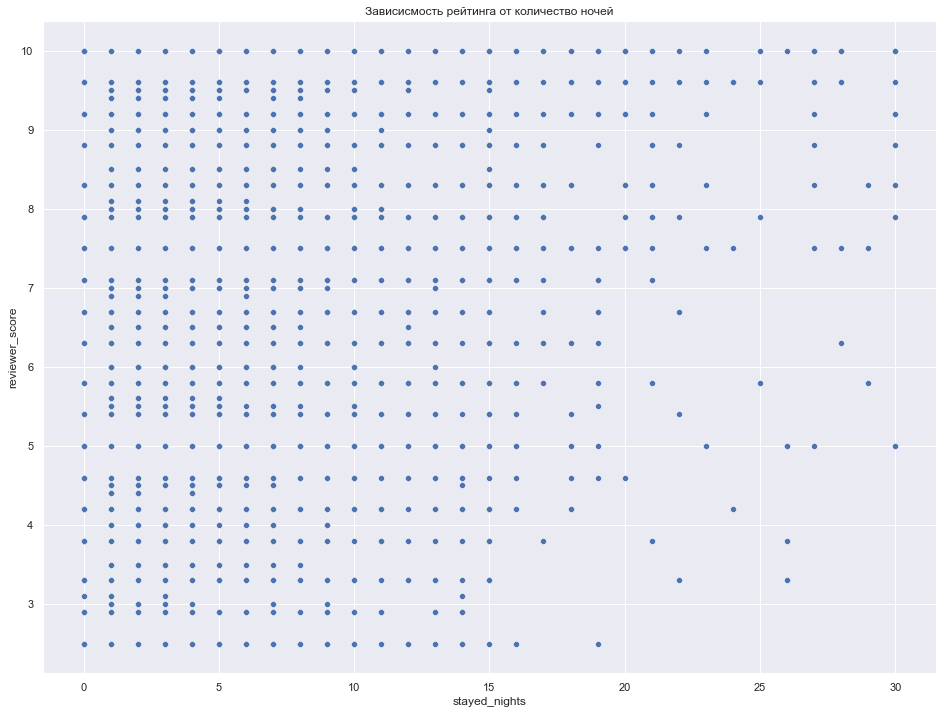

In [872]:
# На трейн датасете проверяю
fig = plt.figure(figsize=(16, 12))
hist = sns.scatterplot(data=full_data[full_data['dataset'] == 'train'], x='stayed_nights', y=TARGET_FEATURE)
hist.set_title('Зависисмость рейтинга от количество ночей');

Видно, что после 15-20 ночей рейтинг растет, в нижней части уже меньше точек, чем в верхней. Но зависимость очень слабая.

In [873]:
# Корреляция нулевая
full_data[full_data['dataset'] == 'train'][['stayed_nights', TARGET_FEATURE]].corr()

,stayed_nights,reviewer_score
stayed_nights,1.00,-0.01
reviewer_score,-0.01,1.00


In [874]:
# Все же считаю признак категориальным номинальным
# Может стоит подумать о снижении числа уникальных значений через группировку:
# 0 - без ночевки. 1 - одна ночь. 2-14 - до двух ниедель. от 15 - от 2х недель. 
category_nominal_columns.add('stayed_nights')

In [875]:
# По маске удаляю теги Stayed, что бы они не мешали дальнейшему анализу
# С помощью ~ инвертирую фильтр
tags_df = tags_df[~stayed_mask].reset_index(drop=True)

In [876]:
# Смотрю еще 60 тегов, дальше нет смысла, частота падает
# tags_df = tags_df.head(60)
# tags_df

In [877]:
# Маска для тегов в которых есть слово Rooom
room_mask = tags_df['tag'].apply(lambda x: x.find('Room') != -1)

In [878]:
# Теги только со словом Room

# Тип кроватей:
# Single - номер на одного
# Twin - две кровати
# Double - одна кровать на двоих
# King
# Queen
# Family
bed_type = ['Single', 'Twin', 'Double', 'King', 'Queen', 'Family']

# Класс удобства:
# Classic
# Standard
# Deluxe
# Executive
# Superior
servise_type = ['Classic', 'Standard', 'Deluxe', 'Executive', 'Superior']

# Тип номера:
# Room
# Studio
# Suite
# Apartment
room_type = ['Room', 'Studio', 'Suite', 'Apartment']


tags_df[room_mask].head(60)

,tag,frequency
7,Double Room,35207
8,Standard Double Room,32246
9,Superior Double Room,31359
11,Deluxe Double Room,24810
12,Double or Twin Room,22393
13,Standard Double or Twin Room,17478
14,Classic Double Room,16865
15,Superior Double or Twin Room,13570
17,Standard Twin Room,9745
18,Single Room,9668


In [879]:
# Теги без слова Room

# 2 rooms - есть еще 3. т.е. номера из 1 (по умолчанию все такие) 2х и 3х комнат. Можно выделить в отдельный признак
# 

# Submitted from a mobile device в современном мире важный показатель, канал коммуникации клиента.

# Думаю топ 15 можно использовать как отдельные признаки. Couple - Solo traveler - Family with young children - Family with older children - 
tags_df[~room_mask].head(60)

,tag,frequency
0,Leisure trip,417513
1,Submitted from a mobile device,307458
2,Couple,252117
3,Solo traveler,108468
4,Business trip,82880
5,Group,65357
6,Family with young children,60986
10,Family with older children,26331
16,2 rooms,12382
29,Junior Suite,4555


### rooms признак количество комнат в номере

In [880]:
def get_rooms_feature(tags):
    # обхожу список тегов
    for tag in tags:
        # если в теге есть слово
        if 'rooms' in tag:
            num_rooms = tag.split()[0]
            
            if num_rooms.lower() == 'two':
                return 2
            elif num_rooms.lower() == 'three':
                return 2
            
            try:
                return int(num_rooms)
            
            except ValueError as e:
                return 1
    
    return 1 # Если обойдя список тегов не нашел тег с количеством комнат, то считаю что это сттандартный однокомнатный номер

In [881]:
full_data['rooms'] = full_data['tags'].apply(get_rooms_feature)

In [882]:
# Получается что 97% номеров с 1 комнатой, признак получается малоинформативным
full_data['rooms'].value_counts(True) * 100

1   97.49
2    2.41
3    0.09
4    0.01
5    0.00
Name: rooms, dtype: float64

In [883]:
# Маска для тегов в которых есть слово именно слово rooom, без вхождения в другие слова типа Bathrooms, Bedrooms.
rooms_mask = tags_df['tag'].apply(lambda x: len(re.findall(r'\brooms\b', x)) > 0)

In [884]:
tags_df[rooms_mask]

,tag,frequency
16,2 rooms,12382
120,3 rooms,474
742,4 rooms,38
1287,Family Suite with two connecting rooms,13
1371,Two Connecting Double and Twin rooms,11
1778,5 rooms,5
2266,Family Suite with adjoining rooms,1


Сделаю признак rooms бинарным, пусть он возвращает True, когда в тегах найдена информация о каком-то количестве комнат.\
Иначем поусть возвращает False это стандартные однокомнатные номера.

In [885]:
def get_rooms_boolean_feature(tags):
    # обхожу список тегов
    for tag in tags:
        # если в теге есть слово rooms
        if len(re.findall(r'\brooms\b', tag)) > 0:
            return True
            
    return False # Если обойдя список тегов не нашел тег со словом room, то считаю номер однокомнатным

In [886]:
full_data['rooms'] = full_data['tags'].apply(get_rooms_boolean_feature)

In [887]:
# Признак по-прежнему малоинформативный, но все же, пока оставлю
full_data['rooms'].value_counts(True) * 100

False   97.49
True     2.51
Name: rooms, dtype: float64

In [893]:
# Категориальный номинальный признак
category_nominal_columns.add('rooms')

In [892]:
# Убираю обработанные теги со словом rooms
tags_df = tags_df[~rooms_mask]

,tag,frequency
0,Leisure trip,417513
1,Submitted from a mobile device,307458
2,Couple,252117
3,Solo traveler,108468
4,Business trip,82880
...,...,...
2392,Small Double Room 1 2 adults,1
2393,Couture Suite,1
2394,Executive Double Room with Spa Fitness Access,1
2395,King Room or Twin Room Disability Access,1


### 0.8. Delete useless features

In [ ]:
# Убираю признаки, которые либо пока, либо вовсе не будут обрабатываться
string_columns = [col_name for col_name in full_data.columns if full_data[col_name].dtypes == 'string']

In [ ]:
full_data.drop(string_columns, axis = 1, inplace=True)
print('Drop columns:', string_columns)

Drop columns: ['hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags']


### 0.9. Code features

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515402 non-null  Int64   
 1   average_score                               515402 non-null  Float64 
 2   review_total_negative_word_counts           515402 non-null  Int64   
 3   total_number_of_reviews                     515402 non-null  Int64   
 4   review_total_positive_word_counts           515402 non-null  Int64   
 5   total_number_of_reviews_reviewer_has_given  515402 non-null  Int64   
 6   days_since_review                           515402 non-null  int64   
 7   lat                                         515402 non-null  Float64 
 8   lng                                         515402 non-null  Float64 
 9   reviewer_score                              515402 non-null

### ONE-HOT ENCODING / BINARY ENCODING
Категориальные номинальные признаки

In [ ]:
cols_to_ohe = ['city', 'is_capital', 'day_of_week', 'month', 'quarter']
full_data = pd.get_dummies(full_data, columns=cols_to_ohe, drop_first=True)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515402 non-null  Int64   
 1   average_score                               515402 non-null  Float64 
 2   review_total_negative_word_counts           515402 non-null  Int64   
 3   total_number_of_reviews                     515402 non-null  Int64   
 4   review_total_positive_word_counts           515402 non-null  Int64   
 5   total_number_of_reviews_reviewer_has_given  515402 non-null  Int64   
 6   days_since_review                           515402 non-null  int64   
 7   lat                                         515402 non-null  Float64 
 8   lng                                         515402 non-null  Float64 
 9   reviewer_score                              515402 non-null

### Ordinal Encoding
Порядковые категориальные признаки

In [ ]:
maplist = [{'col': 'average_score_cat', 'mapping': dict_for_ordinal}]

In [ ]:
oe = ce.OrdinalEncoder(mapping=maplist)
full_data = oe.fit_transform(full_data, return_df=True)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515402 non-null  Int64   
 1   average_score                               515402 non-null  Float64 
 2   review_total_negative_word_counts           515402 non-null  Int64   
 3   total_number_of_reviews                     515402 non-null  Int64   
 4   review_total_positive_word_counts           515402 non-null  Int64   
 5   total_number_of_reviews_reviewer_has_given  515402 non-null  Int64   
 6   days_since_review                           515402 non-null  int64   
 7   lat                                         515402 non-null  Float64 
 8   lng                                         515402 non-null  Float64 
 9   reviewer_score                              515402 non-null

In [ ]:
full_data = hd.reformat_columns(full_data, TARGET_FEATURE)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515402 non-null  Int64   
 1   average_score                               515402 non-null  Float64 
 2   review_total_negative_word_counts           515402 non-null  Int64   
 3   total_number_of_reviews                     515402 non-null  Int64   
 4   review_total_positive_word_counts           515402 non-null  Int64   
 5   total_number_of_reviews_reviewer_has_given  515402 non-null  Int64   
 6   days_since_review                           515402 non-null  int64   
 7   lat                                         515402 non-null  Float64 
 8   lng                                         515402 non-null  Float64 
 9   dataset                                     515402 non-null

### 0.9. Scaling features

full_data

In [149]:
full_data

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,average_score_cat,country,city,country_population,city_population,share_of_country,is_capital,is_reviewer_citizen,tags_num,stayed_nights
0,581,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,8,United Kingdom,London,67948282,7421228,11,True,True,5,2
1,299,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,8,United Kingdom,London,67948282,7421228,11,True,True,4,1
2,32,8.90,Legend Saint Germain by Elegancia,other,No kettle in room,6,406,No Positive,0,14,...,8+,France,Paris,65298930,2110694,3,True,False,5,3
3,34,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,...,7,France,Paris,65298930,2110694,3,True,False,4,1
4,914,8.50,Golden Tulip Amsterdam West,other,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,...,8,Netherlands,Amsterdam,17141544,745811,4,True,False,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515397,53,8.10,Best Western Antares Hotel Concorde,other,No Negative,0,984,nice breakfast,4,14,...,8,Italy,Milan,60446035,1156903,2,False,False,4,4
515398,46,7.80,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,24,1,...,7+,Spain,Barcelona,46757980,1570378,3,False,False,5,2
515399,260,8.00,Suite Hotel 900 m zur Oper,other,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,23,1,...,7+,Austria,Vienna,9015361,1569315,17,True,False,4,2
515400,159,9.00,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,7,...,8+,Italy,Milan,60446035,1156903,2,False,False,5,3


### 0.9. Corralation analysis. Select features

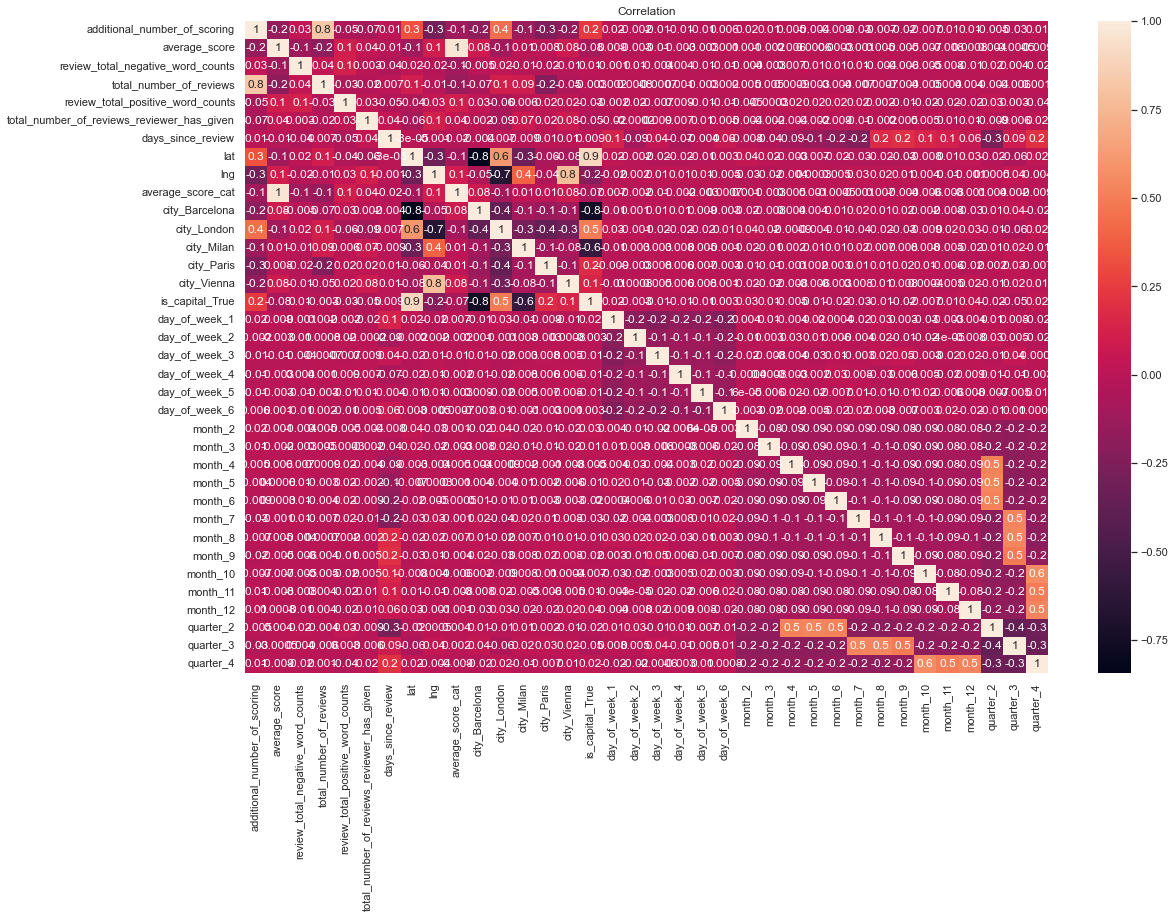

In [ ]:
fig = plt.figure(figsize=(18, 12))
hm = sns.heatmap(full_data.drop(['dataset', TARGET_FEATURE], axis=1).corr(), annot=True, fmt='.1g')
hm.set_title('Correlation');

lat и lng выкидываю, они коррелируют с городами и столицами\
average_score коррелирует с average_score_cat, отбрасываю первый\


In [ ]:
full_data.drop(['lat', 'lng', 'average_score'], axis=1, inplace=True)

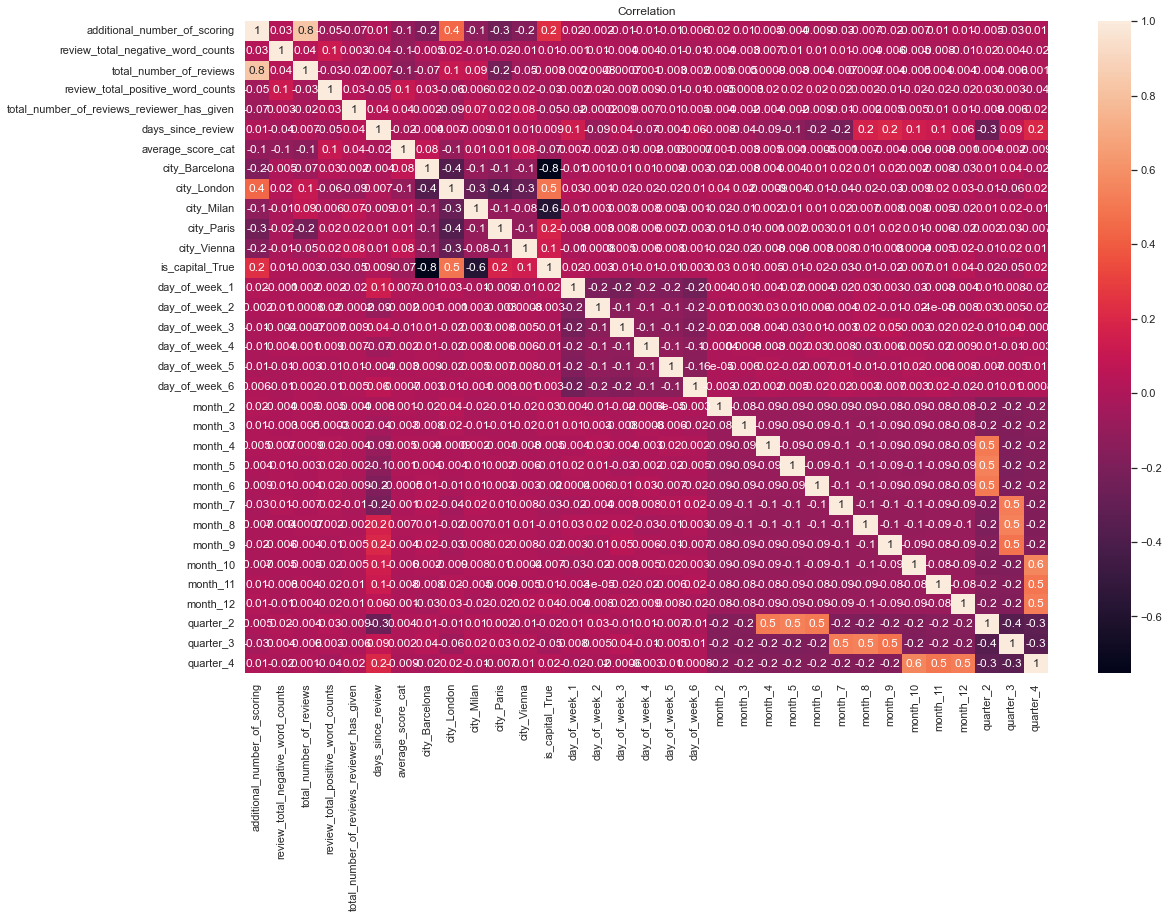

In [ ]:
fig = plt.figure(figsize=(18, 12))
hm = sns.heatmap(full_data.drop(['dataset', TARGET_FEATURE], axis=1).corr(), annot=True, fmt='.1g')
hm.set_title('Correlation');

### Корреляция только категориальных признаков

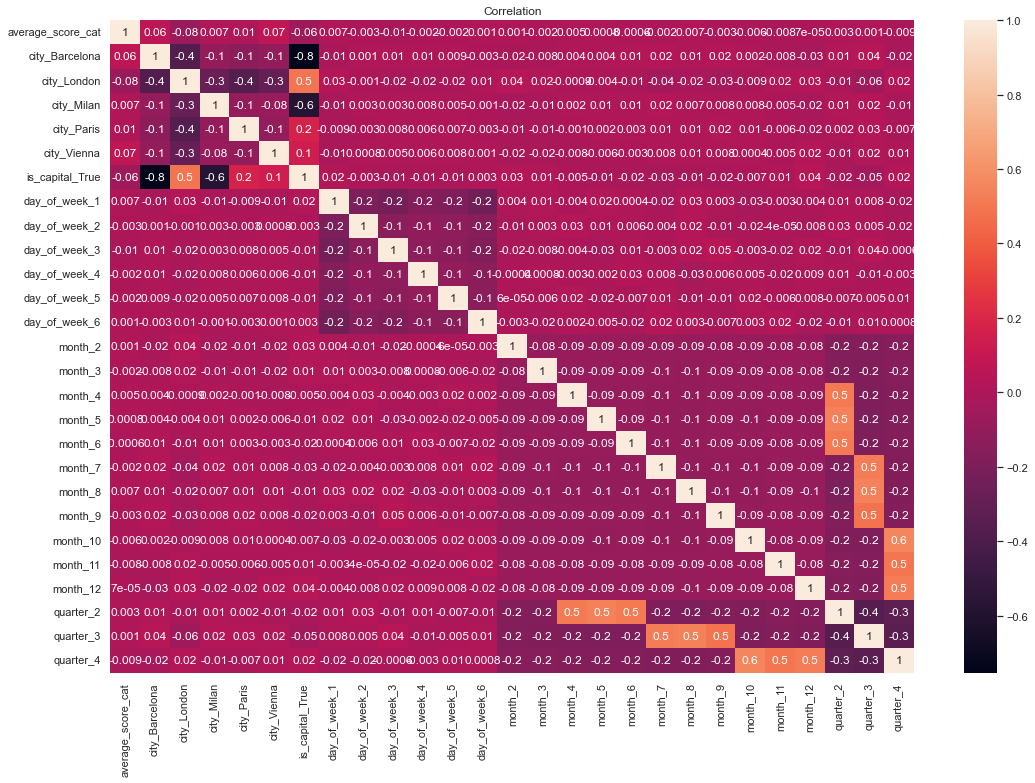

In [ ]:
cat_cols = full_data.columns[7:-1]

fig = plt.figure(figsize=(18, 12))
hm = sns.heatmap(full_data[cat_cols].corr(method='spearman'), annot=True, fmt='.1g')
hm.set_title('Correlation');

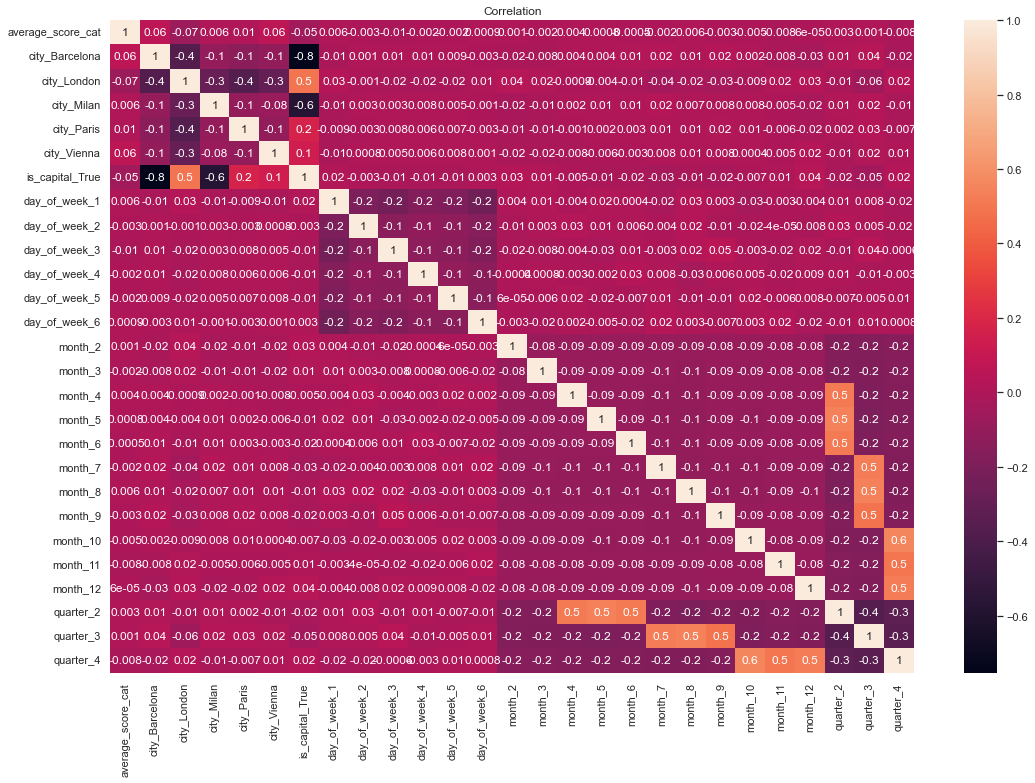

In [ ]:
cat_cols = full_data.columns[7:-1]

fig = plt.figure(figsize=(18, 12))
hm = sns.heatmap(full_data[cat_cols].corr(method='kendall'), annot=True, fmt='.1g')
hm.set_title('Correlation');

### 1.0. Split full dataset to train and test

In [ ]:
train_data, test_data = hd.split_full_to_train_and_test(full_data)

### 1.1. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [ ]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (21698, 15), te_data = (5425, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age
21115,21115,MERCEDES-BENZ,C 250,Sedan,156682,Automatic,4/5,Left wheel,White,NaN,WDDGF4HB6EA905229,1,For Sale,7500,7
17409,17409,VOLKSWAGEN,Passat,Sedan,92000,Automatic,4/5,Left wheel,Grey,Black,1VWAP7A34DC055330,0,For Sale,4600,9
20921,20921,FORD,Escape,Jeep,168966,Automatic,4/5,Left wheel,White,NaN,1FMCU5K31BKB48814,1,For Sale,1150,10
6598,6598,HYUNDAI,Sonata,Sedan,118643,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,6754,9
10439,10439,HYUNDAI,Elantra,Sedan,140000,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,4609,10


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [ ]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [ ]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In [ ]:
automl = TabularAutoML(
# automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 0)

CPU times: total: 46min 48s
Wall time: 12min 57s


In [ ]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.81405 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.18595 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [ ]:
%%time
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[ 3441.752 ],
       [11478.221 ],
       [ 3606.0374],
       ...,
       [ 5871.615 ],
       [ 1594.9069],
       [ 4184.3193]], dtype=float32)
Shape = (5425, 1)
CPU times: total: 23.8 s
Wall time: 6.01 s


In [ ]:
mae0 = mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])
print(f'TRAIN out-of-fold score: {mae0}')
experiment.log_metric('TRAIN out-of-fold score', mae0)


mae1 = mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])
print(f'HOLDOUT score: {mae1}')
experiment.log_metric('HOLDOUT score', mae1)

TRAIN out-of-fold score: 1217.0090492345932
HOLDOUT score: 1210.3088751633816


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In [ ]:
# %%time
# # Fast feature importances calculation
# fast_fi = automl.get_feature_scores('fast')
# fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
# %%time
# # Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
# accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

In [ ]:
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

Для более точного предсказания использую весь датасет train_data

In [ ]:
automl = TabularAutoML(
# automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [ ]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 0)

CPU times: total: 51min 29s
Wall time: 14min 14s


In [ ]:
mae2 = mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])
print(f'FULL TRAIN score: {mae2}')
experiment.log_metric('FULL TRAIN score', mae2)

FULL TRAIN score: 1161.7015939214507


In [ ]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2928.0444],
       [ 5643.253 ],
       [ 2320.2744],
       ...,
       [10300.769 ],
       [ 5064.375 ],
       [ 6414.238 ]], dtype=float32)
Shape = (10697, 1)


In [ ]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission

,row_ID,final_price
0,35000,2928.04
1,35001,5643.25
2,35002,2320.27
3,35003,2126.17
4,35004,5045.77
...,...,...
10692,45692,988.49
10693,45693,1294.45
10694,45694,10300.77
10695,45695,5064.38


### Проверка и замена нулевой записи

In [ ]:
# Должно быть ноль
submission[submission['row_ID'] == 37254]

,row_ID,final_price
2254,37254,2768.71


In [ ]:
# Если не ноль, то принудительно меняю
ind = submission[submission['row_ID'] == 37254].index
submission.at[ind[0], 'final_price'] = 0

In [ ]:
submission.to_csv(submission_file_name, index = False)

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/chepell/predict-car-price/23cda242c5d445f2b20c168e6ed08ca7
COMET INFO:   Metrics:
COMET INFO:     FULL TRAIN score        : 1161.7015939214507
COMET INFO:     HOLDOUT score           : 1210.3088751633816
COMET INFO:     TRAIN out-of-fold score : 1217.0090492345932
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (406.20 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO:     text-sample              : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functional